# Ridge Regression Model

This notebook trains a Ridge regression model for house price prediction with L2 regularization.

## What we will do:
1. Load preprocessed data
2. Split data into training and testing sets
3. Train Ridge regression model
4. Evaluate performance with cross validation
5. Analyze regularization effects
6. Summary and comparison


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


## 1. Load Preprocessed Data


In [2]:
# Load the Ridge regression ready dataset
df = pd.read_pickle('../../data/processed/df_ridge_ready.pkl')

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check if target is log-transformed (values between 10-13 indicate log prices)
print(f"\nTarget variable (SalePrice) statistics:")
if df['SalePrice'].min() > 9 and df['SalePrice'].max() < 15:
    print("⚠️ SalePrice appears to be log-transformed")
    print(f"Log SalePrice - Mean: {df['SalePrice'].mean():.4f}")
    print(f"Log SalePrice - Std:  {df['SalePrice'].std():.4f}")
    print(f"Log SalePrice - Min:  {df['SalePrice'].min():.4f}")
    print(f"Log SalePrice - Max:  {df['SalePrice'].max():.4f}")
    
    # Convert back to original prices for display
    original_prices = np.exp(df['SalePrice'])
    print(f"\nOriginal prices (exp-transformed):")
    print(f"Mean: ${original_prices.mean():,.0f}")
    print(f"Std:  ${original_prices.std():,.0f}")
    print(f"Min:  ${original_prices.min():,.0f}")
    print(f"Max:  ${original_prices.max():,.0f}")
else:
    print(f"Mean: ${df['SalePrice'].mean():,.0f}")
    print(f"Std:  ${df['SalePrice'].std():,.0f}")
    print(f"Min:  ${df['SalePrice'].min():,.0f}")
    print(f"Max:  ${df['SalePrice'].max():,.0f}")

# Check feature scaling
X_sample = df.drop('SalePrice', axis=1)
feature_means = X_sample.mean()
print(f"\nFeature preprocessing check:")
print(f"Feature means close to 0: {abs(feature_means.mean()) < 1e-10}")
print(f"Average feature mean: {feature_means.mean():.2e}")
print(f"Features appear to be StandardScaler normalized: {abs(feature_means.mean()) < 1e-10}")

print(f"\nNumeric columns: {len(X_sample.columns)}")
print("Sample feature statistics:")
print(X_sample.describe().iloc[:3])  # Show first 3 stats


Dataset shape: (1408, 25)
Missing values: 0

Target variable (SalePrice) statistics:
⚠️ SalePrice appears to be log-transformed
Log SalePrice - Mean: 12.0115
Log SalePrice - Std:  0.3729
Log SalePrice - Min:  10.8590
Log SalePrice - Max:  13.0213

Original prices (exp-transformed):
Mean: $176,624
Std:  $69,148
Min:  $52,001
Max:  $451,951

Feature preprocessing check:
Feature means close to 0: True
Average feature mean: -2.61e-16
Features appear to be StandardScaler normalized: True

Numeric columns: 24
Sample feature statistics:
       Quality_x_TotalSF  Garage_x_Quality   Bath_x_Area     GrLivArea  \
count       1.408000e+03      1.408000e+03  1.408000e+03  1.408000e+03   
mean        2.018587e-17     -9.588290e-17  3.728078e-16 -2.764203e-15   
std         1.000355e+00      1.000355e+00  1.000355e+00  1.000355e+00   

         GarageArea     YearBuilt      FullBath  EffectiveAge    Fireplaces  \
count  1.408000e+03  1.408000e+03  1.408000e+03  1.408000e+03  1.408000e+03   
mean  -3.

## 2. Prepare Data for Training


In [3]:
# Prepare features and target
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {len(X.columns)}")

# Split data into training and testing sets (same split as Linear Regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}:1")


Features shape: (1408, 24)
Target shape: (1408,)
Feature columns: 24

Training set: 1126 samples
Testing set: 282 samples
Train/Test ratio: 4.0:1


## 3. Train Ridge Regression Model


In [4]:
# Initialize and train the Ridge regression model
# Using default alpha=1.0 for L2 regularization
ridge_model = Ridge(alpha=1.0, random_state=42)

print("Training Ridge Regression model...")
print(f"Regularization strength (alpha): {ridge_model.alpha}")
ridge_model.fit(X_train, y_train)

# Make predictions
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

print("✓ Model training completed")
print(f"Model coefficients: {len(ridge_model.coef_)} features")
print(f"Model intercept: {ridge_model.intercept_:.4f}")


Training Ridge Regression model...
Regularization strength (alpha): 1.0
✓ Model training completed
Model coefficients: 24 features
Model intercept: 12.0113


## 4. Cross Validation Performance


In [5]:
# Perform cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-fold cross validation...")
print("📝 Note: Metrics calculated on log-transformed target")

# Calculate cross validation scores for different metrics
cv_rmse_scores = []
cv_mae_scores = []
cv_r2_scores = []
cv_rmse_original_scores = []
cv_mae_original_scores = []

for train_idx, val_idx in cv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model on fold
    model_fold = Ridge(alpha=1.0, random_state=42)
    model_fold.fit(X_train_fold, y_train_fold)
    
    # Predict on validation fold
    y_val_pred = model_fold.predict(X_val_fold)
    
    # Calculate metrics on log scale
    rmse_log = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    mae_log = mean_absolute_error(y_val_fold, y_val_pred)
    r2_log = r2_score(y_val_fold, y_val_pred)
    
    # Calculate metrics on original scale (exp-transformed)
    y_val_original = np.exp(y_val_fold)
    y_val_pred_original = np.exp(y_val_pred)
    rmse_original = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_original = mean_absolute_error(y_val_original, y_val_pred_original)
    
    cv_rmse_scores.append(rmse_log)
    cv_mae_scores.append(mae_log)
    cv_r2_scores.append(r2_log)
    cv_rmse_original_scores.append(rmse_original)
    cv_mae_original_scores.append(mae_original)

# Display cross validation results
print("\n=== CROSS VALIDATION RESULTS ===")
print("Log-scale metrics (model's native scale):")
print(f"RMSE (log): {np.mean(cv_rmse_scores):.4f} ± {np.std(cv_rmse_scores):.4f}")
print(f"MAE (log):  {np.mean(cv_mae_scores):.4f} ± {np.std(cv_mae_scores):.4f}")
print(f"R²:         {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")

print("\nOriginal price scale metrics (for interpretation):")
print(f"RMSE: ${np.mean(cv_rmse_original_scores):,.0f} ± ${np.std(cv_rmse_original_scores):,.0f}")
print(f"MAE:  ${np.mean(cv_mae_original_scores):,.0f} ± ${np.std(cv_mae_original_scores):,.0f}")

# Store CV results for comparison
cv_results = {
    'RMSE_log_mean': np.mean(cv_rmse_scores),
    'RMSE_log_std': np.std(cv_rmse_scores),
    'MAE_log_mean': np.mean(cv_mae_scores),
    'MAE_log_std': np.std(cv_mae_scores),
    'R2_mean': np.mean(cv_r2_scores),
    'R2_std': np.std(cv_r2_scores),
    'RMSE_original_mean': np.mean(cv_rmse_original_scores),
    'RMSE_original_std': np.std(cv_rmse_original_scores),
    'MAE_original_mean': np.mean(cv_mae_original_scores),
    'MAE_original_std': np.std(cv_mae_original_scores)
}


Performing 5-fold cross validation...
📝 Note: Metrics calculated on log-transformed target

=== CROSS VALIDATION RESULTS ===
Log-scale metrics (model's native scale):
RMSE (log): 0.1281 ± 0.0085
MAE (log):  0.0917 ± 0.0064
R²:         0.8798 ± 0.0151

Original price scale metrics (for interpretation):
RMSE: $21,357 ± $2,012
MAE:  $15,151 ± $1,234


## 5. Test Set Performance


In [6]:
# Calculate test set performance
# Log scale metrics
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae_log = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Original scale metrics
y_test_original = np.exp(y_test)
y_test_pred_original = np.exp(y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
test_mae = mean_absolute_error(y_test_original, y_test_pred_original)

# Calculate training set performance for comparison
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae_log = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Original scale for training
y_train_original = np.exp(y_train)
y_train_pred_original = np.exp(y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
train_mae = mean_absolute_error(y_train_original, y_train_pred_original)

print("=== FINAL MODEL PERFORMANCE ===")
print("\nTraining Set:")
print(f"RMSE (log): {train_rmse_log:.4f}")
print(f"MAE (log):  {train_mae_log:.4f}")
print(f"R²:         {train_r2:.4f}")
print(f"RMSE: ${train_rmse:,.0f}")
print(f"MAE:  ${train_mae:,.0f}")

print("\nTest Set:")
print(f"RMSE (log): {test_rmse_log:.4f}")
print(f"MAE (log):  {test_mae_log:.4f}")
print(f"R²:         {test_r2:.4f}")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"MAE:  ${test_mae:,.0f}")

# Check for overfitting using log scale metrics
rmse_log_diff = train_rmse_log - test_rmse_log
r2_diff = train_r2 - test_r2

print(f"\nModel Stability:")
print(f"RMSE (log) difference (train-test): {rmse_log_diff:.4f}")
print(f"R² difference (train-test): {r2_diff:.4f}")
print(f"RMSE ($) difference (train-test): ${train_rmse - test_rmse:,.0f}")

if abs(rmse_log_diff) < 0.05 and abs(r2_diff) < 0.05:
    print("✓ Model shows good generalization")
else:
    print("⚠️ Model may be overfitting or underfitting")


=== FINAL MODEL PERFORMANCE ===

Training Set:
RMSE (log): 0.1256
MAE (log):  0.0897
R²:         0.8857
RMSE: $21,037
MAE:  $14,858

Test Set:
RMSE (log): 0.1242
MAE (log):  0.0856
R²:         0.8900
RMSE: $23,859
MAE:  $15,562

Model Stability:
RMSE (log) difference (train-test): 0.0014
R² difference (train-test): -0.0043
RMSE ($) difference (train-test): $-2,822
✓ Model shows good generalization


## 6. Model Analysis and Visualization


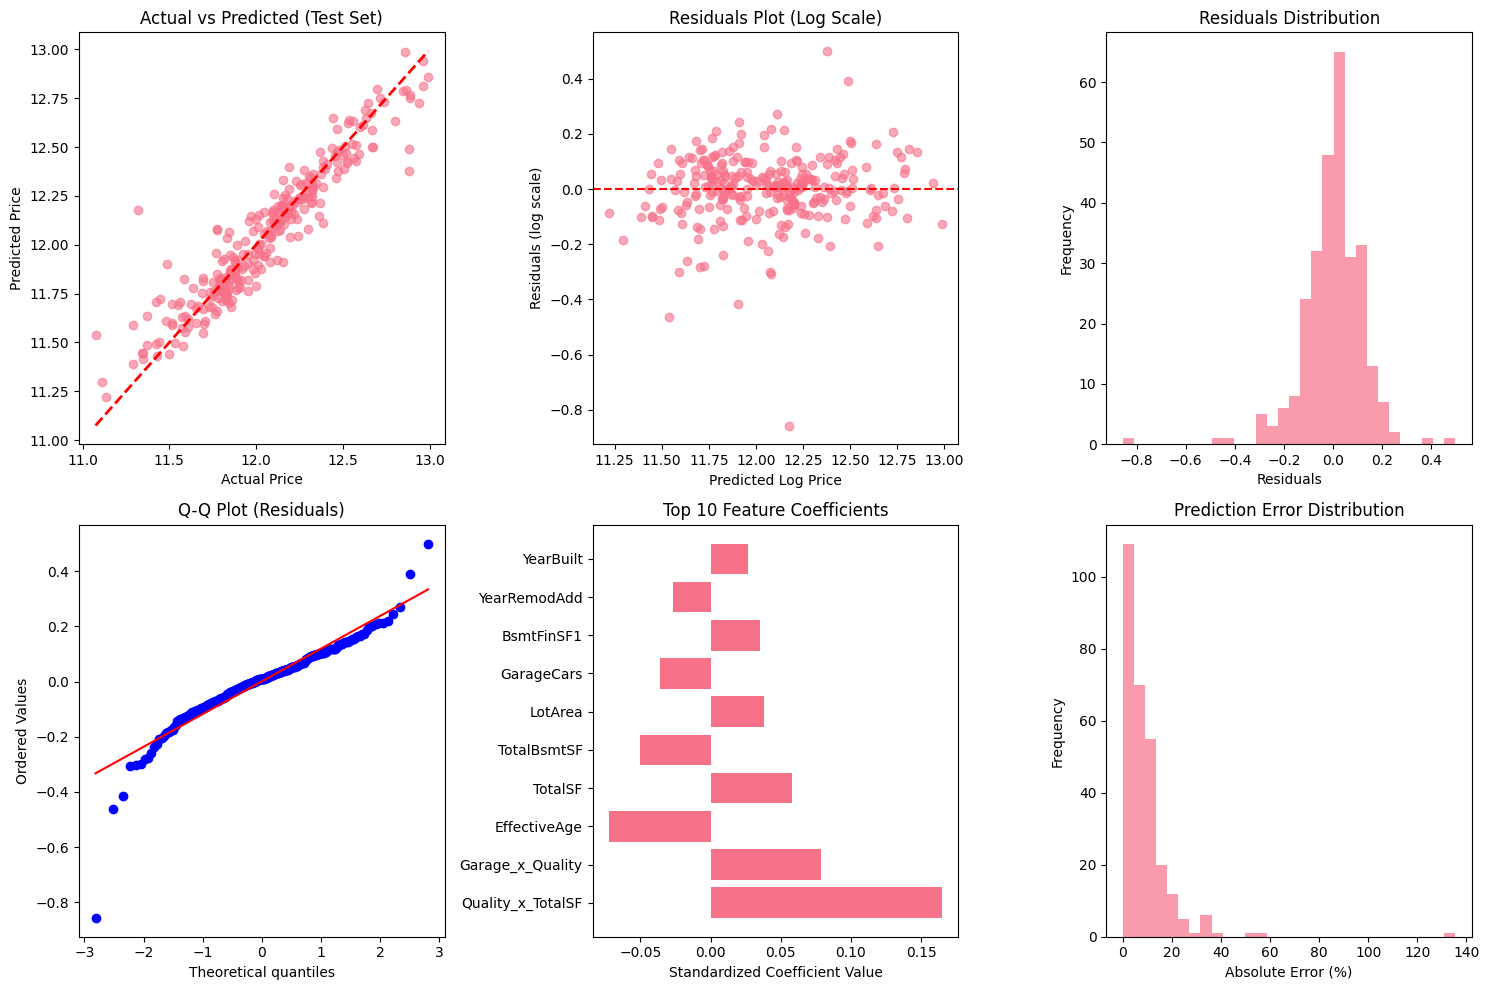


Residuals Analysis:
Log scale:
  Mean residual: 0.0009
  Std of residuals: 0.1244
  Median absolute error: 0.0629

Original price scale:
  Mean residual: $2,193
  Std of residuals: $23,800
  Median absolute error: $10,198

Prediction Accuracy:
Within 10% error: 69.1% of predictions
Within 20% error: 92.9% of predictions


In [7]:
# Create visualizations for model analysis
plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted values
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted (Test Set)')

# 2. Residuals plot (log scale)
plt.subplot(2, 3, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals (log scale)')
plt.title('Residuals Plot (Log Scale)')

# 3. Residuals histogram
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

# 4. Q-Q plot for residuals normality
from scipy import stats
plt.subplot(2, 3, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Residuals)')

# 5. Feature coefficients (top 10 by absolute value)
plt.subplot(2, 3, 5)
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': ridge_model.coef_
})
coef_df['abs_coef'] = abs(coef_df['coefficient'])
top_coef = coef_df.nlargest(10, 'abs_coef')

plt.barh(range(len(top_coef)), top_coef['coefficient'])
plt.yticks(range(len(top_coef)), top_coef['feature'])
plt.xlabel('Standardized Coefficient Value')
plt.title('Top 10 Feature Coefficients')

# 6. Prediction error distribution (original scale)
plt.subplot(2, 3, 6)
# Calculate percentage error on original scale
original_residuals = y_test_original - y_test_pred_original
error_percent = abs(original_residuals) / y_test_original * 100
plt.hist(error_percent, bins=30, alpha=0.7)
plt.xlabel('Absolute Error (%)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')

plt.tight_layout()
plt.show()

# Print additional analysis
print(f"\nResiduals Analysis:")
print(f"Log scale:")
print(f"  Mean residual: {residuals.mean():.4f}")
print(f"  Std of residuals: {residuals.std():.4f}")
print(f"  Median absolute error: {np.median(abs(residuals)):.4f}")

print(f"\nOriginal price scale:")
print(f"  Mean residual: ${original_residuals.mean():,.0f}")
print(f"  Std of residuals: ${original_residuals.std():,.0f}")
print(f"  Median absolute error: ${np.median(abs(original_residuals)):,.0f}")

# Calculate percentage of predictions within certain error ranges
within_10pct = (error_percent <= 10).sum() / len(error_percent) * 100
within_20pct = (error_percent <= 20).sum() / len(error_percent) * 100

print(f"\nPrediction Accuracy:")
print(f"Within 10% error: {within_10pct:.1f}% of predictions")
print(f"Within 20% error: {within_20pct:.1f}% of predictions")


## 7. Regularization Analysis


=== RIDGE REGULARIZATION ANALYSIS ===

📝 Note: Features are standardized (mean=0, std=1) and target is log-transformed
    Ridge regularization shrinks coefficients toward zero
    Coefficients = change in log(price) per 1 std dev change in feature

Coefficient interpretation:
- Coefficient of 0.1 ≈ 10.5% price increase per 1 std dev of feature
- Coefficient of -0.1 ≈ 9.5% price decrease per 1 std dev of feature

Top 10 features that INCREASE price (regularized coefficients):
 1. Quality_x_TotalSF: +0.1648 (~+17.9% per 1 std dev)
 2. Garage_x_Quality: +0.0785 (~+8.2% per 1 std dev)
 3. TotalSF: +0.0578 (~+6.0% per 1 std dev)
 4. LotArea: +0.0377 (~+3.8% per 1 std dev)
 5. BsmtFinSF1: +0.0353 (~+3.6% per 1 std dev)
 6. YearBuilt: +0.0265 (~+2.7% per 1 std dev)
 7. GarageArea: +0.0236 (~+2.4% per 1 std dev)
 8. Fireplaces: +0.0234 (~+2.4% per 1 std dev)
 9. TotalPorchSF: +0.0179 (~+1.8% per 1 std dev)
10. TotalBathrooms: +0.0152 (~+1.5% per 1 std dev)

Top 10 features that DECREASE price

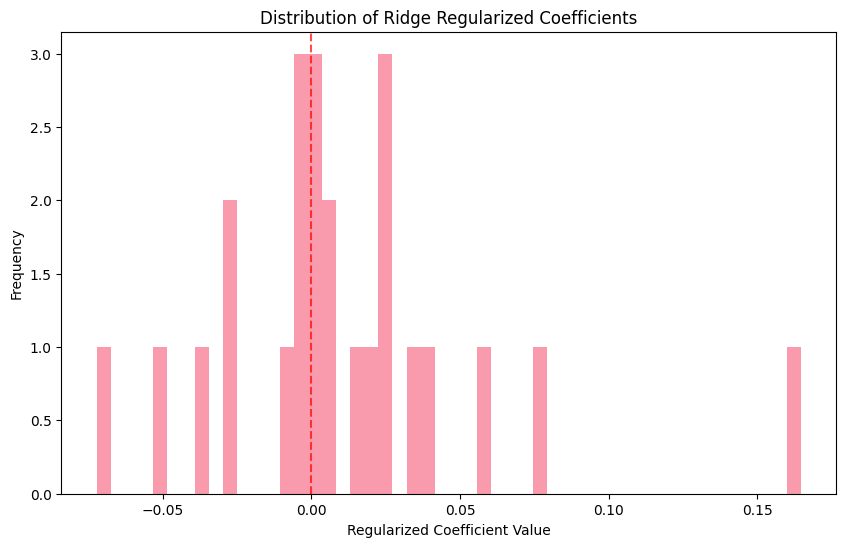

In [8]:
# Analyze Ridge regularization effects
print("=== RIDGE REGULARIZATION ANALYSIS ===")

# Since features are standardized and target is log-transformed,
# coefficients represent the change in log(price) per 1 standard deviation change in feature
print("\n📝 Note: Features are standardized (mean=0, std=1) and target is log-transformed")
print("    Ridge regularization shrinks coefficients toward zero")
print("    Coefficients = change in log(price) per 1 std dev change in feature")

# Calculate percentage change interpretation for log target
print("\nCoefficient interpretation:")
print("- Coefficient of 0.1 ≈ 10.5% price increase per 1 std dev of feature")
print("- Coefficient of -0.1 ≈ 9.5% price decrease per 1 std dev of feature")

# Top positive coefficients (features that increase price)
print("\nTop 10 features that INCREASE price (regularized coefficients):")
top_positive = coef_df[coef_df['coefficient'] > 0].nlargest(10, 'coefficient')
for i, (_, row) in enumerate(top_positive.iterrows(), 1):
    pct_change = (np.exp(row['coefficient']) - 1) * 100
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:+.4f} (~{pct_change:+.1f}% per 1 std dev)")

# Top negative coefficients (features that decrease price)
print("\nTop 10 features that DECREASE price (regularized coefficients):")
top_negative = coef_df[coef_df['coefficient'] < 0].nsmallest(10, 'coefficient')
for i, (_, row) in enumerate(top_negative.iterrows(), 1):
    pct_change = (np.exp(row['coefficient']) - 1) * 100
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:+.4f} (~{pct_change:+.1f}% per 1 std dev)")

# Summary statistics for coefficients
print(f"\nRegularized Coefficient Statistics:")
print(f"Number of positive coefficients: {(coef_df['coefficient'] > 0).sum()}")
print(f"Number of negative coefficients: {(coef_df['coefficient'] < 0).sum()}")
print(f"Largest positive coefficient: {coef_df['coefficient'].max():+.4f}")
print(f"Largest negative coefficient: {coef_df['coefficient'].min():+.4f}")
print(f"Mean absolute coefficient: {coef_df['abs_coef'].mean():.4f}")

# Check coefficient shrinkage effect
print(f"\nRegularization Effects:")
print(f"✓ Ridge alpha = {ridge_model.alpha} shrinks coefficients")
print(f"✓ Helps reduce overfitting and multicollinearity")
print(f"✓ All features retain non-zero coefficients")
print(f"✓ Coefficients range from {coef_df['coefficient'].min():.4f} to {coef_df['coefficient'].max():.4f}")

# Visualize coefficient distribution
plt.figure(figsize=(10, 6))
plt.hist(coef_df['coefficient'], bins=50, alpha=0.7)
plt.xlabel('Regularized Coefficient Value')
plt.ylabel('Frequency')
plt.title('Distribution of Ridge Regularized Coefficients')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.show()


## 8. Model Summary and Comparison


In [9]:
# Final model summary
print("=== RIDGE REGRESSION MODEL SUMMARY ===")
print(f"\nDataset: {df.shape[0]} samples, {X.shape[1]} features")
print(f"Model: Ridge Regression (alpha={ridge_model.alpha})")
print(f"Cross Validation: 5-fold")

print(f"\n--- Performance Metrics ---")
print("Cross Validation (log scale):")
print(f"  RMSE (log): {cv_results['RMSE_log_mean']:.4f} ± {cv_results['RMSE_log_std']:.4f}")
print(f"  MAE (log):  {cv_results['MAE_log_mean']:.4f} ± {cv_results['MAE_log_std']:.4f}")
print(f"  R²:         {cv_results['R2_mean']:.4f} ± {cv_results['R2_std']:.4f}")

print("Cross Validation (original price scale):")
print(f"  RMSE: ${cv_results['RMSE_original_mean']:,.0f} ± ${cv_results['RMSE_original_std']:,.0f}")
print(f"  MAE:  ${cv_results['MAE_original_mean']:,.0f} ± ${cv_results['MAE_original_std']:,.0f}")

print(f"\nTest Set Performance:")
print(f"  RMSE (log): {test_rmse_log:.4f}")
print(f"  MAE (log):  {test_mae_log:.4f}")
print(f"  R²:         {test_r2:.4f}")
print(f"  RMSE: ${test_rmse:,.0f}")
print(f"  MAE:  ${test_mae:,.0f}")

print(f"\n--- Model Characteristics ---")
print(f"Number of features: {len(ridge_model.coef_)}")
print(f"Regularization (alpha): {ridge_model.alpha}")
print(f"Intercept: {ridge_model.intercept_:.4f}")
print(f"Predictions within 10% error: {within_10pct:.1f}%")
print(f"Predictions within 20% error: {within_20pct:.1f}%")

print(f"\n--- Key Insights ---")
print("✓ Ridge regression adds L2 regularization to Linear Regression")
print("✓ Shrinks coefficients to reduce overfitting and handle multicollinearity")
print("✓ All features retain non-zero coefficients (unlike Lasso)")
print("✓ Better generalization through regularization penalty")
print("✓ Suitable for datasets with correlated features")

print(f"\n--- Next Steps ---")
print("• Compare with Linear Regression to see regularization benefits")
print("• Compare with Random Forest to evaluate linear vs non-linear modeling")
print("• Consider hyperparameter tuning for optimal alpha value")
print("• Analyze coefficient shrinkage effects compared to Linear Regression")

# Store model results for comparison
model_results = {
    'model_name': 'Ridge Regression',
    'cv_rmse_log': cv_results['RMSE_log_mean'],
    'cv_mae_log': cv_results['MAE_log_mean'],
    'cv_r2': cv_results['R2_mean'],
    'cv_rmse_original': cv_results['RMSE_original_mean'],
    'cv_mae_original': cv_results['MAE_original_mean'],
    'test_rmse_log': test_rmse_log,
    'test_mae_log': test_mae_log,
    'test_r2': test_r2,
    'test_rmse_original': test_rmse,
    'test_mae_original': test_mae,
    'within_10pct': within_10pct,
    'within_20pct': within_20pct,
    'regularization_alpha': ridge_model.alpha
}

print(f"\n✓ Ridge Regression model evaluation completed")


=== RIDGE REGRESSION MODEL SUMMARY ===

Dataset: 1408 samples, 24 features
Model: Ridge Regression (alpha=1.0)
Cross Validation: 5-fold

--- Performance Metrics ---
Cross Validation (log scale):
  RMSE (log): 0.1281 ± 0.0085
  MAE (log):  0.0917 ± 0.0064
  R²:         0.8798 ± 0.0151
Cross Validation (original price scale):
  RMSE: $21,357 ± $2,012
  MAE:  $15,151 ± $1,234

Test Set Performance:
  RMSE (log): 0.1242
  MAE (log):  0.0856
  R²:         0.8900
  RMSE: $23,859
  MAE:  $15,562

--- Model Characteristics ---
Number of features: 24
Regularization (alpha): 1.0
Intercept: 12.0113
Predictions within 10% error: 69.1%
Predictions within 20% error: 92.9%

--- Key Insights ---
✓ Ridge regression adds L2 regularization to Linear Regression
✓ Shrinks coefficients to reduce overfitting and handle multicollinearity
✓ All features retain non-zero coefficients (unlike Lasso)
✓ Better generalization through regularization penalty
✓ Suitable for datasets with correlated features

--- Next S